# **MNIST Meat**

Implement a simple CNN on the MNIST dataset using Keras. Following this, also add in drop-out layers.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam,SGD

from PIL import Image, ImageOps

In [2]:
# Loading the data... nope use the data provided
#from tensorflow.keras.datasets import mnist
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
df = pd.read_csv('train.csv')
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


## **Observations**
We have 42000 labels and 42000 images of 784 pixels (0-783).  We are guessing these are 28x28 pixel images. Pixel values range from 0 to 1.

In [4]:
# convert our data into a usable form
labels = np.array(df.label)
df.drop('label', inplace=True, axis=1, errors='ignore')
df.head()
images = np.array(df)
images = images.reshape(42000, 28,28)

0

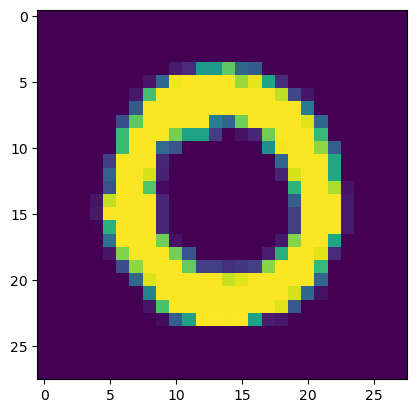

In [5]:
plt.imshow(images[1])
labels[1]

In [6]:
# remove dataframe as we are done with it now
del(df)

# **Check the Distribution of our data**

<BarContainer object of 10 artists>

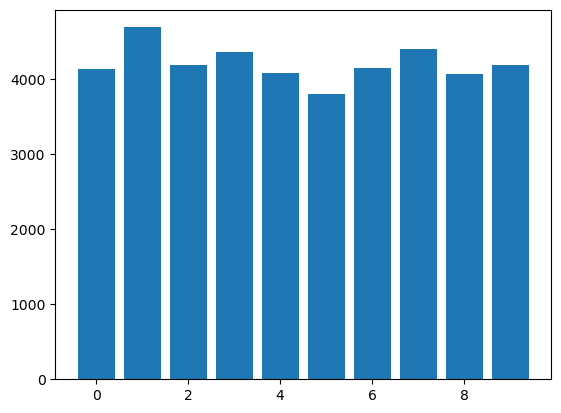

In [7]:
# let's check the distribution of our training set
a,b= np.unique(labels, return_counts=True)
plt.bar(a, b)

We can see that we don't have a even distribution.  Let's split out data such that our training and validation data are balanced.

In [8]:
def get_droplist(images, labels):    
    N_max = np.unique(labels, return_counts=True)[1].min() # nope let's be general
    # now we create a drop list
    indices = [set() for i in range(10)]
    for i in range(10):
        while(np.count_nonzero((labels == i)) - len(indices[i]) > N_max):
            index = int(np.random.randint(0, labels.shape[0], 1)) # pick an index at random
            if(labels[index] == i): # add if it matched this digit
                indices[i].add(index)
    drop_list = set().union(*indices)
    return drop_list

<BarContainer object of 10 artists>

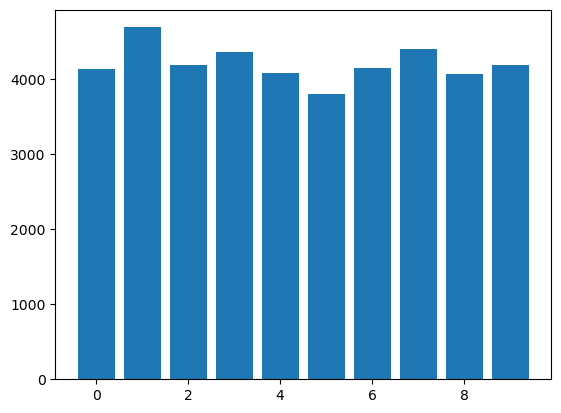

In [9]:
a,b= np.unique(labels, return_counts=True)
plt.bar(a, b)
#assert(False)

In [10]:
# Let's do the split, then we'll drop indices
# 80:20:10

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)
#x_train, x_validate, y_train, y_validate = train_test_split(images, labels, test_size=0.2, random_state=42)

<BarContainer object of 10 artists>

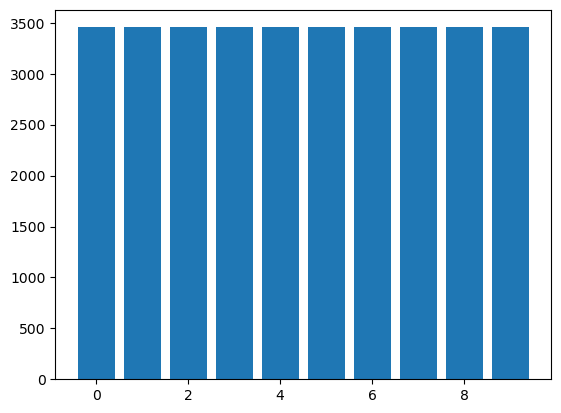

In [12]:
# Balance Training
drop_list = get_droplist(x_train, y_train)
x_train = np.delete(x_train, list(drop_list),0)
y_train = np.delete(y_train, list(drop_list),0)

a,b= np.unique(y_train, return_counts=True)
plt.bar(a, b)

<BarContainer object of 10 artists>

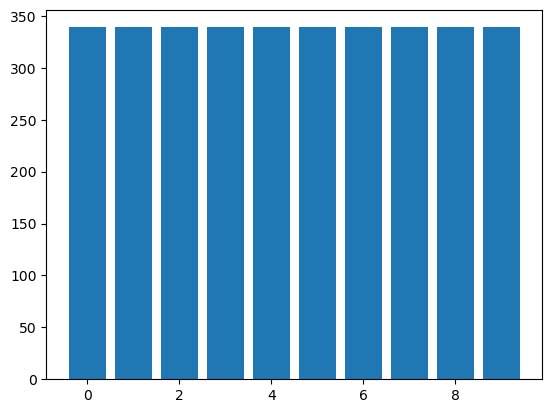

In [14]:
# Balance Test
drop_list = get_droplist(x_test, y_test)
x_test = np.delete(x_test, list(drop_list),0)
y_test = np.delete(y_test, list(drop_list),0)

a,b= np.unique(y_test, return_counts=True)
plt.bar(a, b)

# **Build and train our model**

Now we'll follow the Kera Example for the most part.  Initially we trained using the data provided in the chanallege.  We got a 96% accuracy.  Using the entire MNIST dataset, our model trained to 99% accuracy.  

In [35]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# **Build it**
Buy it, use it, break it, fix it
Trash it, change it, mail – upgrade it
Charge it, point it, zoom it, press it
Snap it, work it, quick – erase it
Write it, cut it, paste it, save it
Load it, check it, quick – rewrite it
Plug it, play it, burn it, rip it
Drag and drop it, zip – unzip it
Lock it, fill it, call it, find it
View it, code it, jam – unlock it
Surf it, scroll it, pause it, click it
Cross it, crack it, switch – update it
Name it, read it, tune it, print it
Scan it, send it, fax – rename it
Touch it, bring it, pay it, watch it
Turn it, leave it, start – format it

--Daft punk, Technologic

In [36]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout  
model = Sequential(
    [
        Input(shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1600)             

In [37]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 32s 74ms/step - loss: 0.3647 - accuracy: 0.8902 - val_loss: 0.0836 - val_accuracy: 0.9765
Epoch 2/15
422/422 [==============================] - 39s 93ms/step - loss: 0.1093 - accuracy: 0.9670 - val_loss: 0.0553 - val_accuracy: 0.9855
Epoch 3/15
422/422 [==============================] - 39s 91ms/step - loss: 0.0822 - accuracy: 0.9742 - val_loss: 0.0440 - val_accuracy: 0.9888
Epoch 4/15
422/422 [==============================] - 37s 86ms/step - loss: 0.0696 - accuracy: 0.9781 - val_loss: 0.0394 - val_accuracy: 0.9898
Epoch 5/15
422/422 [==============================] - 30s 71ms/step - loss: 0.0613 - accuracy: 0.9809 - val_loss: 0.0388 - val_accuracy: 0.9895
Epoch 6/15
422/422 [==============================] - 34s 82ms/step - loss: 0.0543 - accuracy: 0.9836 - val_loss: 0.0369 - val_accuracy: 0.9902
Epoch 7/15
422/422 [==============================] - 32s 76ms/step - loss: 0.0500 - accuracy: 0.9839 - val_loss: 0.0333 - val_accuracy:

# **Evaluate the trained model**

In [30]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.14715361595153809
Test accuracy: 0.9598820209503174


# **Make Priediction**

In [39]:
df = pd.read_csv('train.csv')
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [40]:
# convert our data into a usable form
labels = np.array(df.label)
df.drop('label', inplace=True, axis=1, errors='ignore')
df.head()
images = np.array(df)
images = images.reshape(42000, 28,28)

In [41]:
# Scale images to the [0, 1] range

x_test2 = images.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_test2 = np.expand_dims(x_test2, -1)
print(x_test2.shape[0], "test samples")


# convert class vectors to binary class matrices
y_test2 = tf.keras.utils.to_categorical(labels, num_classes)

42000 test samples


In [44]:
score = model.evaluate(x_test2, y_test2, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.018414171412587166
Test accuracy: 0.9947381019592285


In [49]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, images, labels):
  pred = model.predict(images)  
  pred = np.argmax(pred, axis = 1) 
  y_true = np.argmax(labels, axis = 1)

  # Printing the classification report
  print(classification_report(y_true, pred, digits=2))

  # Plotting the heatmap using confusion matrix
  cm = confusion_matrix(y_true, pred)
  plt.figure(figsize = (8, 5))
  sns.heatmap(cm, annot = True,  fmt = '.part0f')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

1313/1313 [==============================] - 9s 7ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4132
           1       1.00      1.00      1.00      4684
           2       0.99      1.00      0.99      4177
           3       1.00      1.00      1.00      4351
           4       0.99      0.99      0.99      4072
           5       1.00      0.99      0.99      3795
           6       1.00      1.00      1.00      4137
           7       0.99      0.99      0.99      4401
           8       0.99      1.00      0.99      4063
           9       1.00      0.99      0.99      4188

    accuracy                           0.99     42000
   macro avg       0.99      0.99      0.99     42000
weighted avg       0.99      0.99      0.99     42000



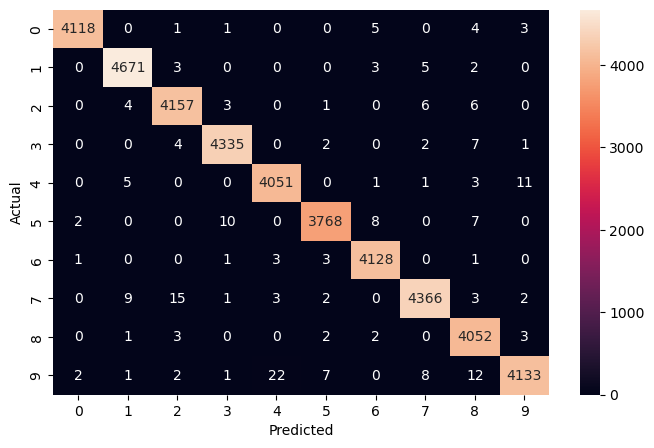

In [50]:
plot_confusion_matrix(model,x_test2, y_test2)